In [ ]:
# ============================================================
# Tip from strain heatmap (B grid) → edge refine → +1 adjacent box
# 2nd box is placed along the crack axis estimated from the heatmap ridge
# ============================================================
from pathlib import Path
import sys, numpy as np, cv2, torch, matplotlib.pyplot as plt
from collections import OrderedDict

#path
BASE      = Path(r"D:\UOB\Dessertation\Code\cracktip_tracking")
RAFT_CORE = BASE / r"models\RAFT\core"
MODEL     = BASE / r"models\raft-small.pth"
IM0       = BASE / r"Croped Images S4\s4_0770.png"   # earlier frame A
IM1       = BASE / r"Croped Images S4\s4_0780.png"   # later  frame B (overlay here)
FRAMES_GLOB= str(BASE / r"Croped Images S4\s4_*.png")   # all frames (we'll sort)

#knobs
MAXDIM         = 896
ITERS          = 8
ROI_BAND       = (0.35, 0.65)
VM_PERCENTILE  = 92.0
RIGHT_MARGIN   = 20
BOX_HALF       = 25
REFINE_WIN_X   = 50
REFINE_WIN_Y   = 25
MEDIAN_PATCH_X = 4
MEDIAN_PATCH_Y = 2
DRIFT_CORRECT   = True           # subtract background drift from ΔL
BG_OFF_Y        = 30             # background patch offset above tip (px)
BOX_HALF        = 25             # (only affects overlay if you add one)
BOX_STEP       = 30

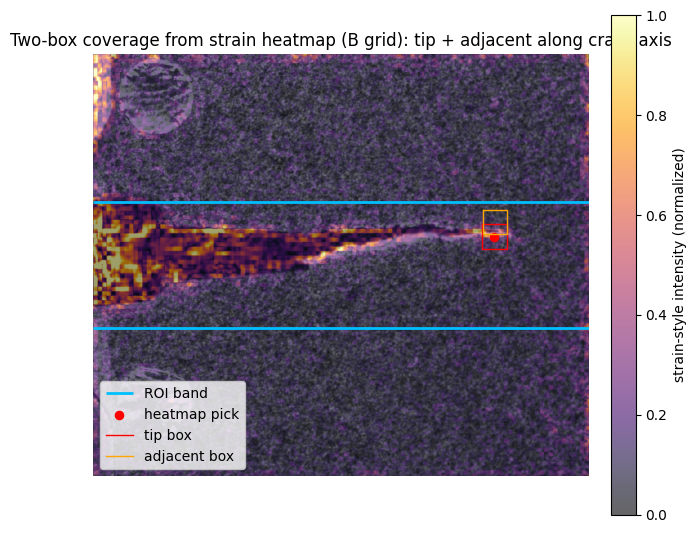

Tip box center   : (x=814,  y=370)
Adjacent box center: (x=815, y=340)
Flow at tip (B->A): dx=0.18, dy=0.74  |  ΔL ≈ 0.77 px


In [ ]:
#helpers
def read_as_rgb(p):
    im = cv2.imread(str(p), cv2.IMREAD_UNCHANGED)
    if im is None: raise FileNotFoundError(p)
    if im.ndim==2:  return cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
    if im.shape[2]==3: return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    if im.shape[2]==4: return cv2.cvtColor(im, cv2.COLOR_BGRA2RGB)
    raise ValueError(f"Unexpected channels in {p}: {im.shape}")

def load_raft_cpu(weights, core):
    sys.path.insert(0, str(core))
    from raft import RAFT
    import argparse as _ap
    sd = torch.load(str(weights), map_location="cpu")
    sd = OrderedDict((k.replace("module.",""), v) for k,v in sd.items())
    for small in (False, True):
        try:
            args = _ap.Namespace(small=small, mixed_precision=False, alternate_corr=False)
            m = RAFT(args); m.load_state_dict(sd, strict=True); return m
        except Exception: pass
    args = _ap.Namespace(small=True, mixed_precision=False, alternate_corr=False)
    m = RAFT(args); m.load_state_dict(sd, strict=False); return m

def sobel(f):
    fx = cv2.Sobel(f, cv2.CV_32F, 1,0, ksize=3)
    fy = cv2.Sobel(f, cv2.CV_32F, 0,1, ksize=3)
    return fx, fy

def pick_rightmost_bright_spot(vm_norm, band, right_margin, pct):
    H,W = vm_norm.shape
    y0,y1 = int(band[0]*H), int(band[1]*H)
    vm_band = vm_norm.copy()
    vm_band[:y0,:] = 0; vm_band[y1:,:] = 0
    vm_band[:, W-right_margin:] = 0
    vals = vm_band[vm_band>0]
    if vals.size == 0:
        yy, xx = np.unravel_index(np.argmax(vm_band), vm_band.shape)
        return int(xx), int(yy)
    thr = np.percentile(vals, pct)
    mask = (vm_band >= thr).astype(np.uint8)*255
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  cv2.getStructuringElement(cv2.MORPH_RECT,(5,3)), 1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT,(5,3)), 1)
    num, lab, *_ = cv2.connectedComponentsWithStats(mask, 8)
    if num <= 1:
        yy, xx = np.unravel_index(np.argmax(vm_band), vm_band.shape)
        return int(xx), int(yy)
    best_lbl, best_xmax = None, -1
    for lbl in range(1, num):
        ys, xs = np.where(lab==lbl)
        if xs.size==0: continue
        xmax = xs.max()
        if xmax > best_xmax:
            best_xmax = xmax; best_lbl = lbl
    ys, xs = np.where(lab==best_lbl)
    x_max = xs.max()
    rows  = ys[xs==x_max]
    k = int(np.argmax(vm_norm[rows, x_max]))
    return int(x_max), int(rows[k])

def auto_canny(img, sigma=0.33):
    v = np.median(img)
    lower = int(max(0, (1.0 - sigma)*v))
    upper = int(min(255, (1.0 + sigma)*v))
    return cv2.Canny(img, lower, upper)

def refine_to_rightmost_edge(grayB, x0, y0, right_margin, win_x, win_y):
    H,W = grayB.shape
    xL, xR = x0, min(W-1-right_margin, x0 + win_x)
    yT, yB = max(0, y0 - win_y), min(H-1, y0 + win_y)
    patch = grayB[yT:yB+1, xL:xR+1].copy()
    patch = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(patch)
    edges = auto_canny(patch, sigma=0.33)
    ys, xs = np.where(edges>0)
    if xs.size == 0: return x0, y0
    xmax = xs.max()
    rows = ys[xs==xmax]
    y_candidates = yT + rows
    j = int(np.argmin(np.abs(y_candidates - y0)))
    return int(xL + xmax), int(y_candidates[j])

#checks & load
assert RAFT_CORE.is_dir() and (RAFT_CORE/"raft.py").exists(), "RAFT core not found"
assert MODEL.exists() and IM0.exists() and IM1.exists(), "Check MODEL/IM0/IM1"
A = read_as_rgb(IM0)
B = read_as_rgb(IM1)
H,W = B.shape[:2]
yb0, yb1 = int(ROI_BAND[0]*H), int(ROI_BAND[1]*H)

#RAFT backward (B->A) so heatmap aligns on B
sys.path.insert(0, str(RAFT_CORE))
from utils.utils import InputPadder
model = load_raft_cpu(MODEL, RAFT_CORE).eval()
scale = min(1.0, float(MAXDIM)/max(H,W))
newW,newH = int(round(W*scale)), int(round(H*scale))
A_s = cv2.resize(A,(newW,newH), cv2.INTER_AREA)
B_s = cv2.resize(B,(newW,newH), cv2.INTER_AREA)
tA = torch.from_numpy(A_s).permute(2,0,1).float().unsqueeze(0)
tB = torch.from_numpy(B_s).permute(2,0,1).float().unsqueeze(0)
pad = InputPadder(tA.shape); tAp,tBp = pad.pad(tA,tB)
with torch.no_grad():
    _, flow_bwd_up = model(tBp, tAp, iters=int(ITERS), test_mode=True)  # B->A

flow_bwd = cv2.resize(flow_bwd_up[0].permute(1,2,0).cpu().numpy()[:newH,:newW,:], (W,H), cv2.INTER_LINEAR) * (1.0/scale)
uB, vB   = flow_bwd[...,0], flow_bwd[...,1]

#strain-style heatmap on B
ux, uy = sobel(uB);  vx, vy = sobel(vB)
vm_B   = np.sqrt((ux - vy)**2 + (uy + vx)**2)
vm_Bn  = np.clip(vm_B / (np.percentile(vm_B, 99.5) + 1e-6), 0, 1)

#rightmost bright spot in the band
xh, yh = pick_rightmost_bright_spot(vm_Bn, ROI_BAND, RIGHT_MARGIN, VM_PERCENTILE)
# refine to the true edge tip (no skeleton)
grayB = cv2.cvtColor(B, cv2.COLOR_RGB2GRAY)
#xt, yt = refine_to_rightmost_edge(grayB, xh, yh, RIGHT_MARGIN, REFINE_WIN_X, REFINE_WIN_Y)
xt,yt = xh,yh
#place a SECOND box to the RIGHT of the tip along the crack axis
SECOND_RIGHT_MARGIN = 5  

# tangent along the ridge (perpendicular to heatmap gradient at the tip)
gmx = cv2.Sobel(vm_Bn, cv2.CV_32F, 1,0,3)
gmy = cv2.Sobel(vm_Bn, cv2.CV_32F, 0,1,3)
tx, ty = -float(gmy[yt, xt]), float(gmx[yt, xt])  # tangent ~ (-gy, gx)
norm = (tx*tx + ty*ty) ** 0.5
if norm < 1e-6:
    tx, ty = 1.0, 0.0  
else:
    tx, ty = tx/norm, ty/norm

# choose the direction that moves RIGHT (larger x)
candR1 = (xt + BOX_STEP*tx, yt + BOX_STEP*ty)
candR2 = (xt - BOX_STEP*tx, yt - BOX_STEP*ty)
x2f, y2f = candR1 if candR1[0] >= candR2[0] else candR2

#clamp to image + ROI band (and keep the whole box on-screen)
x2f = int(np.clip(x2f, BOX_HALF, W-1-BOX_HALF-SECOND_RIGHT_MARGIN))
y2f = int(np.clip(y2f, yb0, yb1))


#flow readout at final (first) tip for ΔL 
x0 = max(0, xt-MEDIAN_PATCH_X); x1 = min(W, xt+MEDIAN_PATCH_X+1)
y0 = max(0, yt-MEDIAN_PATCH_Y); y1 = min(H, yt+MEDIAN_PATCH_Y+1)
dx = float(np.median(uB[y0:y1, x0:x1]))
dy = float(np.median(vB[y0:y1, x0:x1]))
dL_px = (dx**2 + dy**2)**0.5

#show 
plt.figure(figsize=(7,8))
plt.imshow(B, cmap='gray')
hm = plt.imshow(vm_Bn, cmap='inferno', alpha=0.60)
plt.hlines([yb0,yb1], 0, W-1, colors='deepskyblue', linewidth=2, label="ROI band")

#heatmap pick (red dot), final tip box (red), adjacent box (orange)
plt.scatter([xh],[yh], c='red', s=35, marker='o', label='heatmap pick')
s = BOX_HALF
# main (tip) box
plt.plot([xt-s, xt+s, xt+s, xt-s, xt-s],
         [yt-s, yt-s, yt+s, yt+s, yt-s],
         color='red', linewidth=1, label='tip box')
# adjacent box toward interior (along crack axis)
plt.plot([x2f-s, x2f+s, x2f+s, x2f-s, x2f-s],
         [y2f-s, y2f-s, y2f+s, y2f+s, y2f-s],
         color='orange', linewidth=1, label='adjacent box')

cb = plt.colorbar(hm, fraction=0.046, pad=0.04); cb.set_label("strain-style intensity (normalized)")
plt.legend(loc='lower left'); plt.axis('off')
plt.title("Two-box coverage from strain heatmap (B grid): tip + adjacent along crack axis")
plt.show()

print(f"Tip box center   : (x={xt},  y={yt})")
print(f"Adjacent box center: (x={x2f}, y={y2f})")
print(f"Flow at tip (B->A): dx={dx:.2f}, dy={dy:.2f}  |  ΔL ≈ {dL_px:.2f} px")


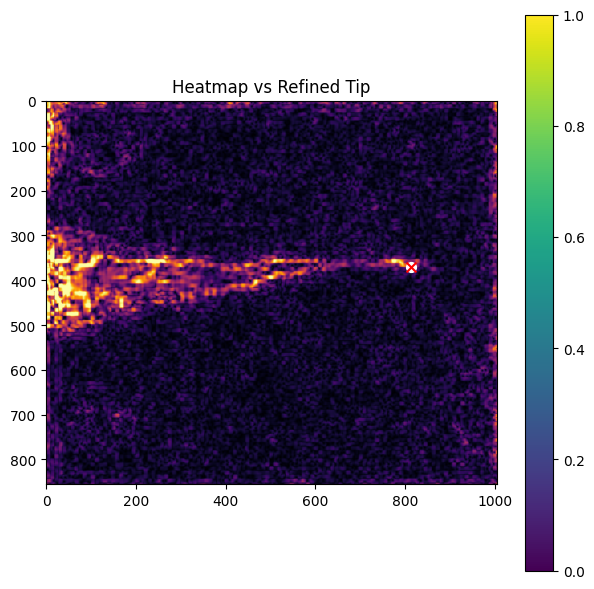

In [16]:
# Only Heat map
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(vm_Bn, cmap='inferno')
plt.scatter(xh, yh, c='white', s=50, marker='o', label='Heatmap pick')
plt.scatter(xt, yt, c='red', s=50, marker='x', label='Refined tip')
plt.title('Heatmap vs Refined Tip')
plt.colorbar()
plt.tight_layout()
plt.show()

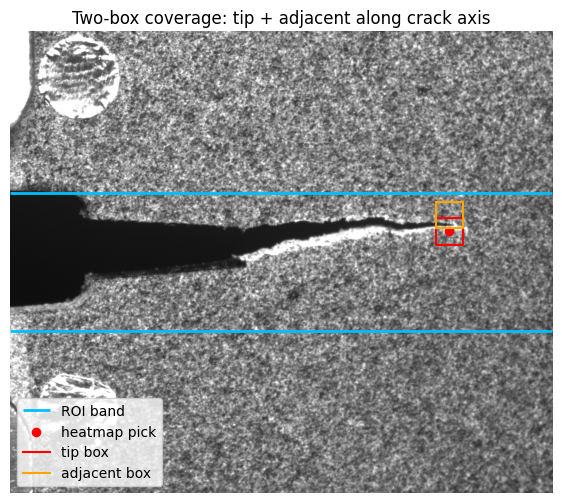

Tip box center   : (x=814,  y=370)
Adjacent box center: (x=815, y=340)
Flow at tip (B->A): dx=0.18, dy=0.74  |  ΔL ≈ 0.77 px


In [ ]:
#show ONLY THE BOXE
plt.figure(figsize=(7,8))
plt.imshow(B)  # Show just the original image, no heatmap overlay
plt.hlines([yb0,yb1], 0, W-1, colors='deepskyblue', linewidth=2, label="ROI band")
# heatmap pick (white dot), final tip box (red), adjacent box (orange)
plt.scatter([xh],[yh], c='red', s=35, marker='o', label='heatmap pick')
s = BOX_HALF
plt.plot([xt-s, xt+s, xt+s, xt-s, xt-s],
         [yt-s, yt-s, yt+s, yt+s, yt-s],
         color='red', linewidth=1.5, label='tip box')
plt.plot([x2f-s, x2f+s, x2f+s, x2f-s, x2f-s],
         [y2f-s, y2f-s, y2f+s, y2f+s, y2f-s],
         color='orange', linewidth=1.5, label='adjacent box')

plt.legend(loc='lower left'); plt.axis('off')
plt.title("Two-box coverage: tip + adjacent along crack axis")
plt.show()

print(f"Tip box center   : (x={xt},  y={yt})")
print(f"Adjacent box center: (x={x2f}, y={y2f})")
print(f"Flow at tip (B->A): dx={dx:.2f}, dy={dy:.2f}  |  ΔL ≈ {dL_px:.2f} px")

Using 79 frames.
A0→A1: tip=(936,456)  dx=-0.02, dy=0.00,  ΔL=0.02px  (s4_0010.png)
A0→A2: tip=(485,488)  dx=-0.02, dy=-0.06,  ΔL=0.06px  (s4_0020.png)
A0→A3: tip=(480,482)  dx=-0.03, dy=-0.11,  ΔL=0.11px  (s4_0030.png)
A0→A4: tip=(500,482)  dx=-0.11, dy=-0.04,  ΔL=0.12px  (s4_0040.png)
A0→A5: tip=(480,482)  dx=-0.12, dy=-0.12,  ΔL=0.17px  (s4_0050.png)
A0→A6: tip=(486,471)  dx=-0.08, dy=-0.13,  ΔL=0.15px  (s4_0060.png)
A0→A7: tip=(505,478)  dx=-0.09, dy=-0.13,  ΔL=0.16px  (s4_0070.png)
A0→A8: tip=(504,476)  dx=-0.11, dy=-0.21,  ΔL=0.24px  (s4_0080.png)
A0→A9: tip=(489,473)  dx=-0.13, dy=-0.27,  ΔL=0.30px  (s4_0090.png)
A0→A10: tip=(493,473)  dx=-0.12, dy=-0.28,  ΔL=0.30px  (s4_0100.png)
A0→A11: tip=(497,478)  dx=-0.20, dy=-0.23,  ΔL=0.31px  (s4_0110.png)
A0→A12: tip=(495,482)  dx=-0.31, dy=-0.26,  ΔL=0.40px  (s4_0120.png)
A0→A13: tip=(475,486)  dx=-0.41, dy=-0.42,  ΔL=0.59px  (s4_0130.png)
A0→A14: tip=(489,463)  dx=-0.13, dy=-0.39,  ΔL=0.41px  (s4_0140.png)
A0→A15: tip=(493,469)  dx=-

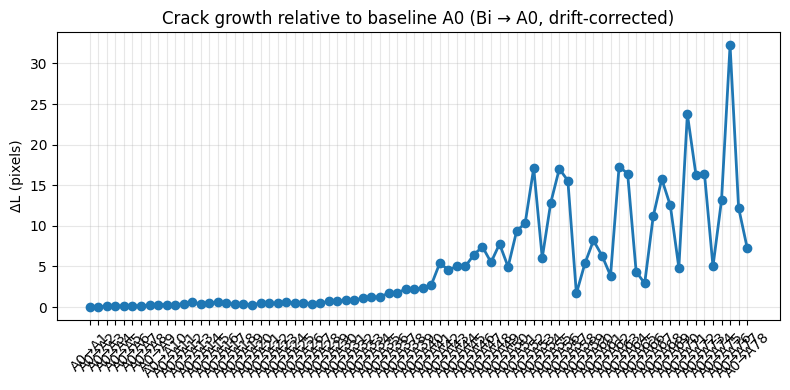

In [ ]:
from pathlib import Path
import sys, re, glob
import numpy as np, cv2, torch, matplotlib.pyplot as plt
from collections import OrderedDict
#helpers
def natural_key(s):  # sort s4_0520, s4_0580, s4_0780 properly
    return [int(t) if t.isdigit() else t for t in re.split(r'(\d+)', str(s))]

def read_as_rgb(p):
    im = cv2.imread(str(p), cv2.IMREAD_UNCHANGED)
    if im is None: raise FileNotFoundError(p)
    if im.ndim==2:  return cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
    if im.shape[2]==3: return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    if im.shape[2]==4: return cv2.cvtColor(im, cv2.COLOR_BGRA2RGB)
    raise ValueError(f"Unexpected channels in {p}: {im.shape}")

def load_raft_cpu(weights, core):
    sys.path.insert(0, str(core))
    from raft import RAFT
    import argparse as _ap
    sd = torch.load(str(weights), map_location="cpu")
    sd = OrderedDict((k.replace("module.",""), v) for k,v in sd.items())
    for small in (False, True):
        try:
            args = _ap.Namespace(small=small, mixed_precision=False, alternate_corr=False)
            m = RAFT(args); m.load_state_dict(sd, strict=True); return m
        except Exception: pass
    args = _ap.Namespace(small=True, mixed_precision=False, alternate_corr=False)
    m = RAFT(args); m.load_state_dict(sd, strict=False); return m

def sobel(f):
    fx = cv2.Sobel(f, cv2.CV_32F, 1,0, ksize=3)
    fy = cv2.Sobel(f, cv2.CV_32F, 0,1, ksize=3)
    return fx, fy

def pick_rightmost_bright_spot(vm_norm, band, right_margin, pct):
    H,W = vm_norm.shape
    y0,y1 = int(band[0]*H), int(band[1]*H)
    vm_band = vm_norm.copy()
    vm_band[:y0,:] = 0; vm_band[y1:,:] = 0
    vm_band[:, W-right_margin:] = 0
    vals = vm_band[vm_band>0]
    if vals.size == 0:
        yy, xx = np.unravel_index(np.argmax(vm_band), vm_band.shape)
        return int(xx), int(yy)
    thr = np.percentile(vals, pct)
    mask = (vm_band >= thr).astype(np.uint8)*255
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  cv2.getStructuringElement(cv2.MORPH_RECT,(5,3)), 1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT,(5,3)), 1)
    num, lab, *_ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num <= 1:
        yy, xx = np.unravel_index(np.argmax(vm_band), vm_band.shape)
        return int(xx), int(yy)
    best_lbl, best_xmax = None, -1
    for lbl in range(1, num):
        ys, xs = np.where(lab==lbl)
        if xs.size==0: continue
        xmax = xs.max()
        if xmax > best_xmax:
            best_xmax = xmax; best_lbl = lbl
    ys, xs = np.where(lab==best_lbl)
    x_max = xs.max()
    rows  = ys[xs==x_max]
    k = int(np.argmax(vm_norm[rows, x_max]))
    return int(x_max), int(rows[k])

def auto_canny(img, sigma=0.33):
    v = np.median(img)
    lower = int(max(0, (1.0 - sigma)*v))
    upper = int(min(255, (1.0 + sigma)*v))
    return cv2.Canny(img, lower, upper)

def refine_to_rightmost_edge(grayB, x0, y0, right_margin, win_x, win_y):
    H,W = grayB.shape
    xL, xR = x0, min(W-1-right_margin, x0 + win_x)
    yT, yB = max(0, y0 - win_y), min(H-1, y0 + win_y)
    patch = grayB[yT:yB+1, xL:xR+1].copy()
    patch = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(patch)
    edges = auto_canny(patch, sigma=0.33)
    ys, xs = np.where(edges>0)
    if xs.size == 0: return x0, y0
    xmax = xs.max()
    rows = ys[xs==xmax]
    y_candidates = yT + rows
    j = int(np.argmin(np.abs(y_candidates - y0)))
    return int(xL + xmax), int(y_candidates[j])

#collect frames 
frames = sorted(glob.glob(FRAMES_GLOB), key=natural_key)
assert len(frames) >= 2, f"Need ≥2 frames; pattern: {FRAMES_GLOB}"
print(f"Using {len(frames)} frames.")
A0_path = Path(frames[0])
later_paths = [Path(p) for p in frames[1:]]

#load baseline and model 
assert RAFT_CORE.is_dir() and (RAFT_CORE/"raft.py").exists(), f"RAFT core not found: {RAFT_CORE}"
assert MODEL.exists(), "Model not found"

A0 = read_as_rgb(A0_path)
H,W = A0.shape[:2]
y_band0, y_band1 = int(ROI_BAND[0]*H), int(ROI_BAND[1]*H)

sys.path.insert(0, str(RAFT_CORE))
from utils.utils import InputPadder
model = load_raft_cpu(MODEL, RAFT_CORE).eval()

#common resize scale (assumes all frames same size)
scale = min(1.0, float(MAXDIM)/max(H,W))
newW, newH = int(round(W*scale)), int(round(H*scale))
A0s = cv2.resize(A0,(newW,newH), cv2.INTER_AREA)
tA0 = torch.from_numpy(A0s).permute(2,0,1).float().unsqueeze(0)

#loop over later frames: Bi 
tip_xy = []
dL_vals = []
labels  = []

for i, Bpath in enumerate(later_paths, start=1):
    B = read_as_rgb(Bpath)
    assert B.shape[:2] == (H,W), "All frames must share resolution"
    Bs = cv2.resize(B,(newW,newH), cv2.INTER_AREA)
    tB = torch.from_numpy(Bs).permute(2,0,1).float().unsqueeze(0)

    #Backward flow Bi->A0 (on B grid after resize/pad)
    pad = InputPadder(tA0.shape)  # both [1,3,newH,newW]
    tA0p, tBp = pad.pad(tA0, tB)
    with torch.no_grad():
        _, flow_bwd_up = model(tBp, tA0p, iters=int(ITERS), test_mode=True)

    flow_bwd_s = flow_bwd_up[0].permute(1,2,0).cpu().numpy()[:newH,:newW,:]
    flow_bwd   = cv2.resize(flow_bwd_s, (W,H), cv2.INTER_LINEAR) * (1.0/scale)
    uB, vB     = flow_bwd[...,0], flow_bwd[...,1]

    #Strain-style heatmap on B (so overlay and sampling align)
    ux, uy = sobel(uB);  vx, vy = sobel(vB)
    vmB    = np.sqrt((ux - vy)**2 + (uy + vx)**2)
    vmBn   = np.clip(vmB / (np.percentile(vmB, 99.5)+1e-6), 0, 1)

    # Tip on B. rightmost bright spot in band, then edge-refine to geometric tip
    xh, yh = pick_rightmost_bright_spot(vmBn, ROI_BAND, RIGHT_MARGIN, VM_PERCENTILE)
    grayB  = cv2.cvtColor(B, cv2.COLOR_RGB2GRAY)
    xt, yt = refine_to_rightmost_edge(grayB, xh, yh, RIGHT_MARGIN, REFINE_WIN_X, REFINE_WIN_Y)

    # ΔL at tip. backward flow magnitude (optionally drift-corrected)
    kx, ky = MEDIAN_PATCH_X, MEDIAN_PATCH_Y
    x0 = max(0, xt-kx); x1 = min(W, xt+kx+1)
    y0 = max(0, yt-ky); y1 = min(H, yt+ky+1)
    dx_tip = float(np.median(uB[y0:y1, x0:x1]))
    dy_tip = float(np.median(vB[y0:y1, x0:x1]))

    if DRIFT_CORRECT:
        # background patch above the band (avoid crack)
        bg_y1 = max(0, y0 - 10)
        bg_y0 = max(0, bg_y1 - BG_OFF_Y)
        bg_dx = float(np.median(uB[bg_y0:bg_y1, x0:x1])) if bg_y1>bg_y0 else 0.0
        bg_dy = float(np.median(vB[bg_y0:bg_y1, x0:x1])) if bg_y1>bg_y0 else 0.0
        dx, dy = dx_tip - bg_dx, dy_tip - bg_dy
    else:
        dx, dy = dx_tip, dy_tip

    dL = (dx*dx + dy*dy) ** 0.5
    dL_vals.append(dL)
    tip_xy.append((xt,yt))
    labels.append(f"A0→A{i}")

    print(f"{labels[-1]}: tip=({xt},{yt})  dx={dx:.2f}, dy={dy:.2f},  ΔL={dL:.2f}px  ({Path(Bpath).name})")

#plot
plt.figure(figsize=(8,4))
plt.plot(range(1, len(dL_vals)+1), dL_vals, marker='o', linewidth=2)
plt.xticks(range(1, len(dL_vals)+1), labels, rotation=45)
plt.ylabel("ΔL (pixels)")
plt.title("Crack growth relative to baseline A0 (Bi → A0, drift-corrected)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

D:\UOB\Dessertation\Code\cracktip_tracking\models\RAFT\core\raft.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
D:\UOB\Dessertation\Code\cracktip_tracking\models\RAFT\core\raft.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
D:\UOB\Dessertation\Code\cracktip_tracking\models\RAFT\core\raft.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):


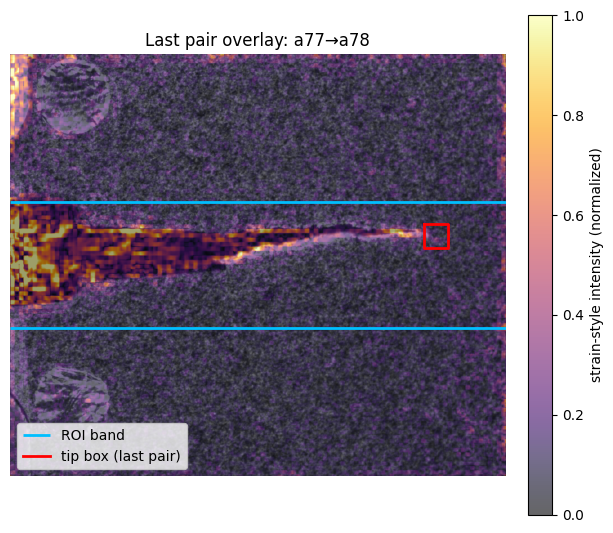

In [ ]:
#LAST PAIR OVERLAY
RIGHT_MARGIN   = 10     
#preview overlay for the last processed pair 
if SHOW_EXAMPLE_PAIR:
    B = read_as_rgb(Path(frames[-1]))
    H,W = B.shape[:2]
    # re-make vm_Bn and tip for the last pair just for drawing
    A_prev = read_as_rgb(Path(frames[-2]))
    scale = min(1.0, float(MAXDIM)/max(H,W))
    newW,newH = int(round(W*scale)), int(round(H*scale))
    A_s = cv2.resize(A_prev,(newW,newH), cv2.INTER_AREA)
    B_s = cv2.resize(B,(newW,newH), cv2.INTER_AREA)
    tA = torch.from_numpy(A_s).permute(2,0,1).float().unsqueeze(0)
    tB = torch.from_numpy(B_s).permute(2,0,1).float().unsqueeze(0)
    pad = InputPadder(tA.shape); tAp,tBp = pad.pad(tA,tB)
    with torch.no_grad():
        _, flow_bwd_up = model(tBp, tAp, iters=int(ITERS), test_mode=True)
    flow_bwd = cv2.resize(flow_bwd_up[0].permute(1,2,0).cpu().numpy()[:newH,:newW,:], (W,H), cv2.INTER_LINEAR) * (1.0/scale)
    uB, vB = flow_bwd[...,0], flow_bwd[...,1]
    ux, uy = sobel(uB);  vx, vy = sobel(vB)
    vm_B   = np.sqrt((ux - vy)**2 + (uy + vx)**2)
    vm_Bn  = np.clip(vm_B / (np.percentile(vm_B, 99.5) + 1e-6), 0, 1)
    xh, yh = pick_rightmost_bright_spot(vm_Bn, ROI_BAND, RIGHT_MARGIN, VM_PERCENTILE)
    grayB  = cv2.cvtColor(B, cv2.COLOR_RGB2GRAY)
    xt, yt = refine_to_rightmost_edge(grayB, xh, yh, RIGHT_MARGIN, REFINE_WIN_X, REFINE_WIN_Y)

    yb0, yb1 = int(ROI_BAND[0]*H), int(ROI_BAND[1]*H)
    plt.figure(figsize=(7,8))
    plt.imshow(B, cmap='gray')
    hm = plt.imshow(vm_Bn, cmap='inferno', alpha=0.60)
    plt.hlines([yb0,yb1], 0, W-1, colors='deepskyblue', linewidth=2, label="ROI band")
    s = BOX_HALF
    plt.plot([xt-s, xt+s, xt+s, xt-s, xt-s],
             [yt-s, yt-s, yt+s, yt+s, yt-s],
             color='red', linewidth=2, label='tip box (last pair)')
    cb = plt.colorbar(hm, fraction=0.046, pad=0.04); cb.set_label("strain-style intensity (normalized)")
    plt.legend(loc='lower left'); plt.axis('off')
    plt.title(f"Last pair overlay: {pair_labels[-1]}")
    plt.show()


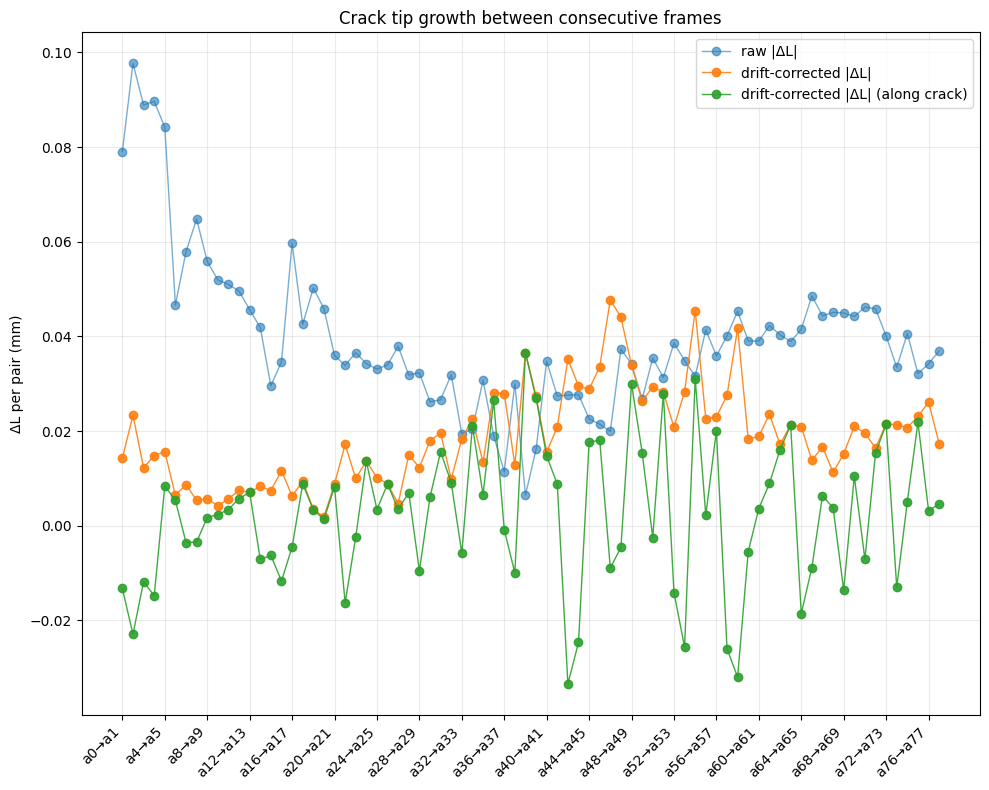

In [ ]:
#CRACK GROWTH PLOTING
DRIFT_ABOVE_PIX = (60, 20)   # (height, clearance below top)
#process pairs 
labels, dL_raw, dL_corr, dL_along = [], [], [], []
H=W=None

for i in range(len(frames)-1):
    A_path, B_path = Path(frames[i]), Path(frames[i+1])
    A = read_as_rgb(A_path)
    B = read_as_rgb(B_path)
    if H is None:
        H, W = B.shape[:2]
        yb0, yb1 = int(ROI_BAND[0]*H), int(ROI_BAND[1]*H)

    # RAFT backward (B->A) on B grid
    scale = min(1.0, float(MAXDIM)/max(H,W))
    newW,newH = int(round(W*scale)), int(round(H*scale))
    A_s = cv2.resize(A,(newW,newH), cv2.INTER_AREA)
    B_s = cv2.resize(B,(newW,newH), cv2.INTER_AREA)
    tA = torch.from_numpy(A_s).permute(2,0,1).float().unsqueeze(0)
    tB = torch.from_numpy(B_s).permute(2,0,1).float().unsqueeze(0)
    pad = InputPadder(tA.shape); tAp,tBp = pad.pad(tA,tB)
    with torch.no_grad():
        _, flow_bwd_up = model(tBp, tAp, iters=int(ITERS), test_mode=True)
    flow = cv2.resize(flow_bwd_up[0].permute(1,2,0).cpu().numpy()[:newH,:newW,:], (W,H), cv2.INTER_LINEAR) * (1.0/scale)
    uB, vB = flow[...,0], flow[...,1]

    #strain-style heatmap on B (for tip & tangent)
    ux, uy = sobel(uB);  vx, vy = sobel(vB)
    vm   = np.sqrt((ux - vy)**2 + (uy + vx)**2)
    vmn  = np.clip(vm / (np.percentile(vm, 99.5) + 1e-6), 0, 1)

    #tip from heatmap, then edge refine
    xh, yh = pick_rightmost_bright_spot(vmn, ROI_BAND, RIGHT_MARGIN, VM_PERCENTILE)
    grayB  = cv2.cvtColor(B, cv2.COLOR_RGB2GRAY)
    xt, yt = refine_to_rightmost_edge(grayB, xh, yh, RIGHT_MARGIN, REFINE_WIN_X, REFINE_WIN_Y)

    #raw flow at tip (median patch)
    x0 = max(0, xt-MEDIAN_PATCH_X); x1 = min(W, xt+MEDIAN_PATCH_X+1)
    y0 = max(0, yt-MEDIAN_PATCH_Y); y1 = min(H, yt+MEDIAN_PATCH_Y+1)
    dx_tip = float(np.median(uB[y0:y1, x0:x1]))
    dy_tip = float(np.median(vB[y0:y1, x0:x1]))
    dL_raw.append((dx_tip**2 + dy_tip**2) ** 0.5)

    # drift estimate from a background strip above the slot band
    h, clr = DRIFT_ABOVE_PIX
    y_top = max(0, yb0 - clr - h)
    y_bot = max(1, yb0 - clr)
    bg_dx = float(np.median(uB[y_top:y_bot, :]))
    bg_dy = float(np.median(vB[y_top:y_bot, :]))

    dx_c, dy_c = dx_tip - bg_dx, dy_tip - bg_dy
    dL_corr.append((dx_c**2 + dy_c**2) ** 0.5)

    # along-axis projection 
    gmx = cv2.Sobel(vmn, cv2.CV_32F, 1,0,3)
    gmy = cv2.Sobel(vmn, cv2.CV_32F, 0,1,3)
    tx, ty = -float(gmy[yt, xt]), float(gmx[yt, xt])
    nrm = (tx*tx + ty*ty) ** 0.5
    if nrm < 1e-6: tx, ty, nrm = 1.0, 0.0, 1.0
    tx, ty = tx/nrm, ty/nrm
    dL_along.append(dx_c*tx + dy_c*ty)  # can be +/-; usually >0 toward earlier frame

    labels.append(f"a{i}→a{i+1}")

# convert to mm if needed
if PX_PER_MM:
    dL_raw   = [v/float(PX_PER_MM) for v in dL_raw]
    dL_corr  = [v/float(PX_PER_MM) for v in dL_corr]
    dL_along = [v/float(PX_PER_MM) for v in dL_along]
    unit = "mm"
else:
    unit = "px"

#plot 
x = np.arange(len(labels))
plt.figure(figsize=(10,8))
plt.plot(x, dL_raw,   marker='o', linewidth=1.0, alpha=0.6, label="raw |ΔL|")
plt.plot(x, dL_corr,  marker='o', linewidth=1.0, alpha=0.9, label="drift-corrected |ΔL|")
plt.plot(x, dL_along, marker='o', linewidth=1.0, alpha=0.9, label="drift-corrected |ΔL| (along crack)")
#tick every N labels to avoid clutter
N = max(1, len(labels)//16)
plt.xticks(x[::N], [labels[i] for i in x[::N]], rotation=45, ha='right')
plt.ylabel(f"ΔL per pair ({unit})")
plt.title("Crack tip growth between consecutive frames")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


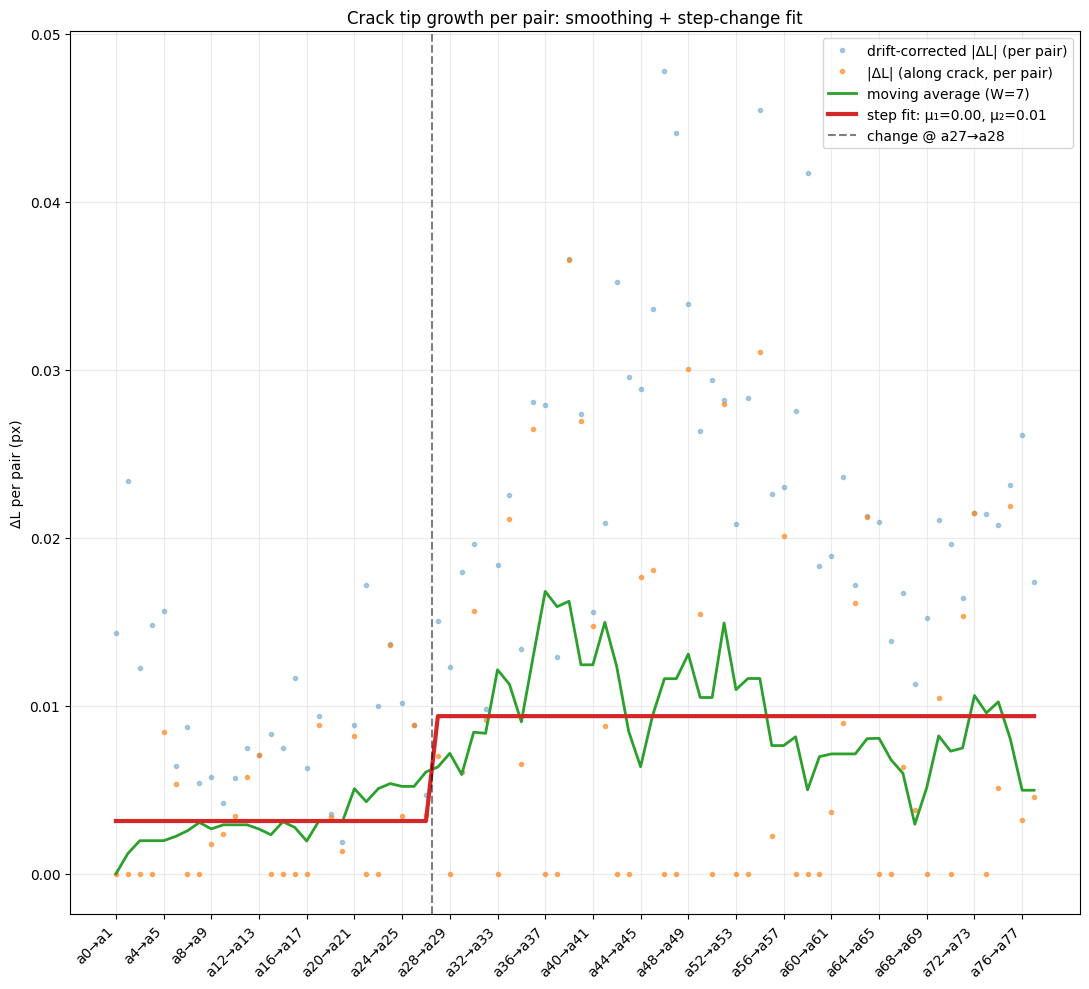

In [ ]:


#smooth + step-change fit on drift-corrected along-crack ΔL
y = np.array(dL_along, dtype=float)          # drift-corrected, along crack axis
y = np.maximum(y, 0)                          

#smooth (simple moving average)
W = 7                                        
kernel = np.ones(W) / W
y_ma = np.convolve(y, kernel, mode='same')

# 3) single step-change fit (piecewise-constant): find k that minimises SSE
def best_step_fit(arr, min_seg=8):
    N = len(arr)
    best = None
    for k in range(min_seg, N-min_seg):
        m1 = arr[:k].mean()
        m2 = arr[k:].mean()
        err = ((arr[:k]-m1)**2).sum() + ((arr[k:]-m2)**2).sum()
        if best is None or err < best[0]:
            best = (err, k, m1, m2)
    return best  # (err, k, m1, m2)

err, k, m1, m2 = best_step_fit(y_ma, min_seg=8)
step = np.r_[np.full(k, m1), np.full(len(y_ma)-k, m2)]

# 4) plot
x = np.arange(len(labels))
Ntick = max(1, len(labels)//16)

plt.figure(figsize=(11,10))
plt.plot(x, np.array(dL_corr),'.', alpha=0.35, label='drift-corrected |ΔL| (per pair)')
plt.plot(x, y,'.', alpha=0.6,  label='|ΔL| (along crack, per pair)')
plt.plot(x, y_ma,'-', linewidth=2, label=f'moving average (W={W})')
plt.plot(x, step,'-', linewidth=3, label=f'step fit: μ₁={m1:.2f}, μ₂={m2:.2f}')
plt.axvline(k-0.5, color='k', ls='--', alpha=0.5, label=f'change @ {labels[k]}')

plt.xticks(x[::Ntick], [labels[i] for i in x[::Ntick]], rotation=45, ha='right')
plt.ylabel('ΔL per pair (px)')
plt.title('Crack tip growth per pair: smoothing + step-change fit')
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


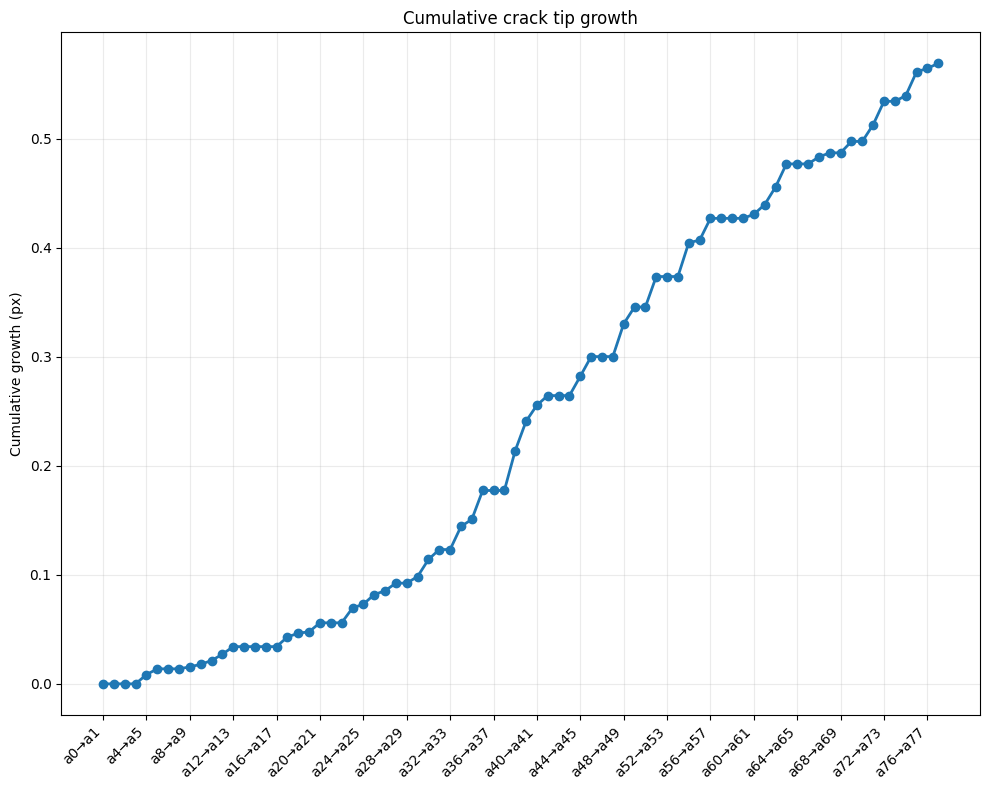

In [26]:
cum = np.cumsum(y)  # monotonic cumulative displacement from the first pair
plt.figure(figsize=(10,8))
plt.plot(cum, '-o', linewidth=2)
plt.xticks(x[::Ntick], [labels[i] for i in x[::Ntick]], rotation=45, ha='right')
plt.ylabel('Cumulative growth (px)')
plt.title('Cumulative crack tip growth')
plt.grid(True, alpha=0.25)
plt.tight_layout(); plt.show()   